# Capstone - Financial Forecasting

Import fundamental packages

In [3]:
import pandas as pd
import numpy as np
from numpy import newaxis
#import pandas_datareader.data as web
import datetime
from datetime import timedelta
import seaborn as sn
from pandas import Series
from matplotlib import pyplot
from pandas import Series
from matplotlib import pyplot
# Pretty display for notebooks
%matplotlib inline
from IPython.display import display # Allows the use of display() for DataFrames
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from matplotlib.pyplot import savefig
import time
from scipy.misc import imresize
from sklearn.preprocessing import MinMaxScaler

# 1. Get financial data 

Run this section if you want to download the data yourself. It is not compulsary, as the data is stored as "Data-5year-2012-2017.csv", and loaded in the relevant sections.

- Financial data is downloaded via the quandl API (https://www.quandl.com/)
    - Time interval: 2012-01-01 -- 2017-01-01
    - Data type: Adj. Close from NASDAQ 100 (Here: Only 88 companies, 12 had too many missing values)
- .csv file is saved on HDD for later processing

Download data from quandl

In [5]:
import quandl
quandl.ApiConfig.api_key = "U5cJSsnv4Ad7UUnHNGu8"

In [6]:
#Nasdaq 100 Company list
companies = ["WIKI/ATVI.11","WIKI/ADBE.11","WIKI/AKAM.11","WIKI/ALXN.11","WIKI/GOOGL.11","WIKI/AMZN.11","WIKI/AAL.11","WIKI/AMGN.11","WIKI/ADI.11","WIKI/AAPL.11","WIKI/AMAT.11","WIKI/ADSK.11","WIKI/ADP.11","WIKI/BIDU.11","WIKI/BIIB.11","WIKI/BMRN.11","WIKI/CA.11","WIKI/CELG.11","WIKI/CERN.11","WIKI/CHKP.11","WIKI/CTAS.11","WIKI/CSCO.11","WIKI/CTXS.11","WIKI/CTSH.11","WIKI/CMCSA.11","WIKI/COST.11","WIKI/CSX.11","WIKI/XRAY.11","WIKI/DISCA.11","WIKI/DISH.11","WIKI/DLTR.11","WIKI/EBAY.11","WIKI/EA.11","WIKI/EXPE.11","WIKI/ESRX.11","WIKI/FAST.11","WIKI/FISV.11","WIKI/GILD.11","WIKI/HAS.11","WIKI/HSIC.11","WIKI/HOLX.11","WIKI/IDXX.11","WIKI/ILMN.11","WIKI/INCY.11","WIKI/INTC.11","WIKI/INTU.11","WIKI/ISRG.11","WIKI/JBHT.11","WIKI/KLAC.11","WIKI/LRCX.11","WIKI/LBTYA.11","WIKI/MAR.11","WIKI/MAT.11","WIKI/MXIM.11","WIKI/MCHP.11","WIKI/MU.11","WIKI/MDLZ.11","WIKI/MSFT.11","WIKI/MNST.11","WIKI/MYL.11","WIKI/NFLX.11","WIKI/NVDA.11","WIKI/ORLY.11","WIKI/PCAR.11","WIKI/PAYX.11","WIKI/PCLN.11","WIKI/QCOM.11","WIKI/REGN.11","WIKI/ROST.11","WIKI/STX.11","WIKI/SIRI.11","WIKI/SWKS.11","WIKI/SBUX.11","WIKI/SYMC.11","WIKI/TSLA.11","WIKI/TXN.11","WIKI/TSCO.11","WIKI/TMUS.11","WIKI/FOX.11","WIKI/ULTA.11","WIKI/VRSK.11","WIKI/VRTX.11","WIKI/VIAB.11","WIKI/VOD.11","WIKI/WBA.11","WIKI/WDC.11","WIKI/WYNN.11","WIKI/XLNX.11"]

In [7]:
#Download via API
tickerstart = time.time()
mydata = quandl.get(companies, start_date="2012-01-01", end_date="2017-01-01")
tickerend = time.time()
print(tickerend-tickerstart)

65.14187097549438


In [8]:
#save as csv
mydata.to_csv("Data-5year-2012-2017.csv")

# 2. Develop ordering algorithm for companies (PCA)

In this section the sorting algorithm is explained. Run this section if you want to check for functionality. However it is not compulsary as the PC are loaded from HDD in the appropirate sections.

Idea: Cluster data into groups to get some order into financial data. This ordered data can then be used to create images which are processed with DNN image processing techniques.
Ordering process: 
- Generate 5 year image of NASDAQ 100 
- Generate 1 Dimensional feature space with PCA 
- Sort companies by PC eigenvalue

In [9]:
#load data from hdd
mydata=pd.read_csv("Data-5year-2012-2017.csv")
mydata[['Date']] = mydata[['Date']].apply(pd.to_datetime, errors='ignore')
mydata=mydata.set_index(mydata["Date"])
mydata = mydata.drop("Date",axis=1)

In [10]:
#check for nans. Nancheck.csv contains list of columns with NaN indication.
output = pd.isnull(mydata).sum() > 0
output.to_csv("Nancheck.csv")
print(pd.isnull(mydata).sum().sum())

0


In [11]:
#Select 5 year timeinterval
AdjCloseLong = mydata.loc["2012-1-1":"2017-1-1"]

#Bring into shape for image
arraylong = np.flip(np.transpose(np.array(AdjCloseLong, np.float32)[:, :]),axis=1)
dfLong = pd.DataFrame(arraylong)

In [12]:
AdjCloseLong.head(5)

,WIKI/ATVI - Adj. Close,WIKI/ADBE - Adj. Close,WIKI/AKAM - Adj. Close,WIKI/ALXN - Adj. Close,WIKI/GOOGL - Adj. Close,WIKI/AMZN - Adj. Close,WIKI/AAL - Adj. Close,WIKI/AMGN - Adj. Close,WIKI/ADI - Adj. Close,WIKI/AAPL - Adj. Close,...,WIKI/FOX - Adj. Close,WIKI/ULTA - Adj. Close,WIKI/VRSK - Adj. Close,WIKI/VRTX - Adj. Close,WIKI/VIAB - Adj. Close,WIKI/VOD - Adj. Close,WIKI/WBA - Adj. Close,WIKI/WDC - Adj. Close,WIKI/WYNN - Adj. Close,WIKI/XLNX - Adj. Close
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,11.477656,28.57,32.93,70.57,333.735209,179.03,13.303512,56.676913,30.734273,52.848787,...,15.598020,63.384438,39.36,32.23,40.245928,26.898992,29.271975,27.306007,91.264785,28.039940
2012-01-04,11.388281,28.28,32.44,70.29,335.174652,177.51,13.069661,56.367493,30.691622,53.132802,...,15.497765,65.629098,38.98,32.20,40.237162,26.794234,29.068329,27.588057,89.695258,27.741735
2012-01-05,11.392985,28.48,32.43,72.41,330.525300,177.61,14.212931,56.942130,30.828105,53.722681,...,15.639793,68.783487,39.13,33.12,41.175153,26.437104,28.970933,28.874913,88.758346,27.988078
2012-01-06,11.515288,28.72,32.76,74.45,326.016381,182.61,14.550716,57.251551,30.623381,54.284287,...,15.539538,68.743934,39.37,34.05,41.595934,26.522815,29.289684,29.518340,85.635308,27.806562
2012-01-09,11.477656,28.53,32.61,74.27,312.193712,178.56,14.862517,56.756478,31.220494,54.198183,...,15.539538,69.149357,39.38,35.68,40.850801,26.341870,29.661560,29.747506,85.395075,28.411616


In [13]:
AdjCloseLong.describe()

,WIKI/ATVI - Adj. Close,WIKI/ADBE - Adj. Close,WIKI/AKAM - Adj. Close,WIKI/ALXN - Adj. Close,WIKI/GOOGL - Adj. Close,WIKI/AMZN - Adj. Close,WIKI/AAL - Adj. Close,WIKI/AMGN - Adj. Close,WIKI/ADI - Adj. Close,WIKI/AAPL - Adj. Close,...,WIKI/FOX - Adj. Close,WIKI/ULTA - Adj. Close,WIKI/VRSK - Adj. Close,WIKI/VRTX - Adj. Close,WIKI/VIAB - Adj. Close,WIKI/VOD - Adj. Close,WIKI/WBA - Adj. Close,WIKI/WDC - Adj. Close,WIKI/WYNN - Adj. Close,WIKI/XLNX - Adj. Close
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,...,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,22.226302,65.095218,52.089247,135.770213,543.855351,406.004230,38.328121,117.034692,47.477466,88.143001,...,27.242712,134.672903,64.466432,83.430071,55.136270,29.738342,60.122436,60.531728,117.061722,39.834672
std,9.963667,23.842798,12.779935,35.293812,158.929535,182.712524,8.671458,33.675673,9.945561,20.965031,...,5.178962,54.210958,11.625000,27.980155,14.826161,3.620722,20.160292,21.652809,40.528512,6.872013
min,10.077590,28.280000,27.440000,70.290000,280.390539,175.930000,13.069661,56.367493,30.167507,50.928800,...,15.497765,63.384438,38.980000,32.200000,29.889198,23.410218,26.021507,25.384539,49.373289,26.791623
25%,13.897245,42.925000,40.805000,102.682500,406.893541,266.627500,33.237752,88.546633,40.089028,70.194775,...,24.471376,92.650000,58.765000,61.037500,41.628140,27.733697,42.429018,41.765654,90.357447,33.759438
50%,19.917526,68.115000,52.655000,132.282500,548.590000,333.060000,38.761908,114.364869,46.831193,89.182554,...,28.224109,115.570000,63.560000,81.405000,52.652905,29.100620,62.687877,57.948526,101.545992,40.599762
75%,30.283465,83.517500,60.935000,167.797500,681.140000,534.012500,43.230474,148.049196,55.235263,106.912899,...,31.510640,165.722500,73.907500,104.830000,68.685975,30.740785,79.413694,79.697765,141.986306,44.573863
max,45.197507,110.810000,78.360000,207.840000,835.740000,844.360000,63.399547,170.848455,73.090050,126.931724,...,36.182463,275.890000,85.750000,141.480000,81.034143,41.839635,92.848360,105.021682,227.514450,60.231455


Normalize for each company as preparation for PCA

In [14]:
from sklearn import preprocessing
x = dfLong.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dfLong_scaled = pd.DataFrame(x_scaled)

Perform PCA and reduce to 1 Dimension

In [15]:
from sklearn.decomposition import PCA
# Apply PCA with one dimension
Transform2D = PCA(n_components=1)
pca = Transform2D.fit(dfLong_scaled)

reduced_data = pca.transform(dfLong_scaled)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1'])

In [16]:
reduced_data.head(5)

,Dimension 1
0,-2.144533
1,-0.720443
2,-1.079834
3,1.815657
4,15.566684


Plot results of PC as histogram

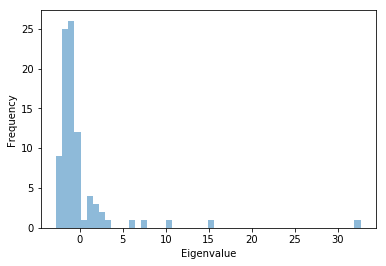

In [17]:
plt.hist(reduced_data["Dimension 1"], bins=50,alpha=0.5)
plt.xlabel('Eigenvalue')
plt.ylabel('Frequency')
plt.show()

Save PC for sorting in later data processing

In [18]:
np.save("PCAForSorting",reduced_data["Dimension 1"])
preds = reduced_data["Dimension 1"]

Test: Sort by PCA and plot results

In [19]:
dfLong["PCA"] = reduced_data["Dimension 1"]
SortedLong = dfLong.sort_values("PCA")
dfLongSorteddisplay = SortedLong.drop('PCA', 1)

Image of unsorted companies

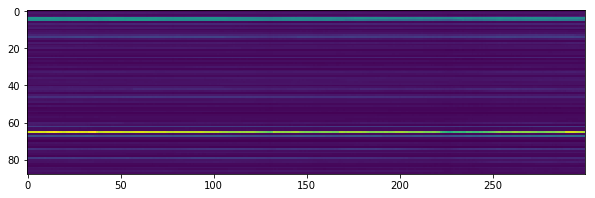

In [20]:
dfLongdisplay = dfLong.drop('PCA', 1)
displaynp = dfLongdisplay.values
plt.figure(figsize=(10,10))
plt.imshow(displaynp[:,:300])
savefig("unsorted_PCA.pdf")
plt.show()

Image of sorted companies

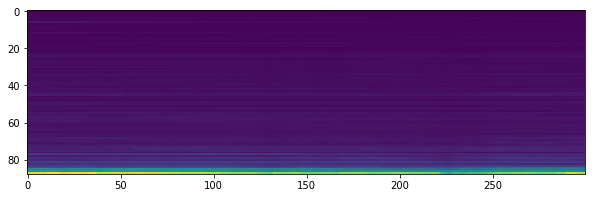

In [21]:
displaynp = dfLongSorteddisplay.values
plt.figure(figsize=(10,10))
plt.imshow(displaynp[:,:300])
savefig("sorted_PCA.pdf")
plt.show()